<a href="https://colab.research.google.com/github/jelade/Neural-Network-from-scratch/blob/main/Jaleel_NN_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(1)
from IPython import display

In [54]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [376]:

path= '/content/drive/MyDrive/diabetes.csv'
data= pd.read_csv(path)
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [377]:
def scale(x):
  """
  Parameters
  -------
    x: dataframe

  Returns
  -------
    x_scaled: dataframe
  
  """
  x_scaled= (x-np.mean(x, axis = 0))/np.std(x)
  return x_scaled

In [378]:
def split_data(df, train_percent= 0.8):
  """
  Parameters
  -------
    df: a dataframe
    train_percent: a float
    

  Returns
  -------
    
    x_train: an array
    x_test: an array 
    y_train: an array
    y_test: an array
  
  """

  X = df.iloc[:,:-1]
  y= df.iloc[:,-1]
  np.random.seed(0) # To demonstrate that if we use the same seed value twice, we will get the same random number twice
  
  #train_size = 0.8
  n = int(X.shape[0]*train_percent)
  indices = np.arange(X.shape[0])
  np.random.shuffle(indices)
  train_idx = indices[: n]
  test_idx = indices[n:]
  x_train, y_train = X.iloc[train_idx,:], y[train_idx]
  x_test, y_test = X.iloc[test_idx,:], y[test_idx]

  return x_train, x_test, y_train, y_test

In [379]:
x_train, x_test, y_train, y_test= split_data(data) 
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((614, 8), (614,), (154, 8), (154,))

In [380]:
x_train = scale(x_train).to_numpy()
x_test = scale(x_test).to_numpy()
y_test = y_test.to_numpy()
y_train = y_train.to_numpy()

In [381]:
def sigmoid(x):
  """
  Parameters
  ----------
    x: an array

  return
  ------

    y: 1/(1+exp(-x))

      a list of value between 0 and 1
  """

  y = 1/(1+ np.exp(-x))
  return y

In [382]:
def dsigmoid(x):
  """
  Parameters
  ----------
    x: an array

  return
  ------

    y: sigmoid(x)*(1- sigmoid(x))

      a list of value of the derivative of sigmoid
  """

  y = sigmoid(x)*(1- sigmoid(x))
  return y

In [399]:
def cross_entropy(y,y_pred):
  """
  Parameters
  ----------
    y: an array
    y_pred: array

  return
  ------
   : float
  """
  loss = -(np.mean((y*np.log(y_pred))+(1-y)*np.log(1-y_pred)))
  return loss

In [400]:
def forward_pass(x, w1, b1, w2, b2):
  """
  Parameters
  ---------
    x: an array of N rows
    w1: an array of shape (hidden_dim, input_dim)
    b1: an array of shape (hidden_dim, 1). Bias vector
    w2: an array of shape (output_dim, hidden_dim)
    b2: an array of shape (1, 1)
  
  Return
  ------
    z1: an array of shape (N, hidden_dim)
    a1: an array of shape (N, hidden_dim)
    z2: an array of shape (N, output_dim)
    a2: an array of shape (N, output_dim)
  """
  z1=  w1@x.T + b1
  a1= sigmoid(z1)

  z2= w2@a1 + b2
  a2= sigmoid(z2)


  return z1, a1, z2, a2

In [401]:
def backwardpass(x,y, w1, b1, w2, b2):
  """
  Parameters
  ---------
    x:  an array of N rows
    y:  an array of N rows
    w1: an array of shape (hidden_dim, input_dim)
    b1: an array of shape (hidden_dim, 1). Bias vector
    w2: an array of shape (output_dim, hidden_dim)
    b2: an array of shape (1, 1)
  
  Return
  ------
    dw1: an array of shape (hidden_dim, input_dim)
    db1: an array of shape (hidden_dim, 1). Bias vector
    dw2: an array of shape (output_dim, hidden_dim)
    db2: an array of shape (1, 1)
  """
  
  # Forward pass
  
  z1, a1, z2, a2= forward_pass(x, w1, b1, w2, b2)
  m = x.shape[0]
  #Backward
  dw1= ((w2.T@(a2-y)*dsigmoid(z1))@x)/m
  db1= np.sum((w2.T@(a2-y))*(dsigmoid(z1)), axis = 1, keepdims=True)/m




  dw2= ((a2-y)@a1.T)/m
  db2= np.sum(a2-y, axis = 1, keepdims = True)/m

  return dw1, db1, dw2, db2

In [402]:
def train(x,y, x_val, y_val):
  """
  Parameters
  ---------
    x:  an array of N rows
    y:  an array of N rows
    w1: an array of shape (hidden_dim, input_dim)
    b1: an array of shape (hidden_dim, 1). Bias vector
    w2: an array of shape (output_dim, hidden_dim)
    b2: an array of shape (1, 1)
  
  Return
  ------
    cost: an array of shape (num_epochs, )
    cost_test: an array of shape (num_epochs, ).
    w1: an array of shape (hidden_dim, input_dim)
    b1: an array of shape (hidden_dim, 1). Bias vector
    w2: an array of shape (output_dim, hidden_dim)
    b2: an array of shape (1, 1)
  """
  input_dim= x.shape[1] # number of features
  hidden_dim=16  # number of units in the hideen layer
  output_dim= 1 # number of units in the output layer
  w1 = np.random.rand(hidden_dim, input_dim)*0.01 # (hidden_dim, input_dim)
  b1 = np.random.rand(hidden_dim,1) # (hidden_dim, 1)

  w2 = np.random.rand(output_dim, hidden_dim)*0.01 # (output_dim, hidden_dim)
  b2 = np.random.rand(output_dim, 1) # (output_dim, 1)
  lr = 0.001
  num_epochs = 1000

  cost =[]
  cost_test= []

  for i in range(num_epochs):
      # Backward Pass
      dw1, db1, dw2, db2 = backwardpass(x,y, w1, b1, w2, b2)

      # Update weights
      w1 = w1 - (lr*dw1)
      b1= b1- (lr*db1)


      w2 = w2 - (lr*dw2)
      b2= b2- (lr*db2)
      # Get the Train Loss
      # apply forward to get z1, a1, z2 and a2
      z1, a1, z2, a2 = forward_pass(x, w1, b1, w2, b2)

      #Compute the loss
      loss_train = cross_entropy(y,a2)
      cost.append(loss_train)


      # Get the Test Loss
      # apply forward to get z1, a1, z2 and a2 using x_val

      z1, a1, z2, a2 = forward_pass(x_val, w1, b1, w2, b2)
      loss_test = cross_entropy(y_val,a2)
      cost_test.append(loss_test)
  
  return cost, cost_test, w1, b1, w2, b2

In [404]:
def accuracy(y, y_pred):
  acc= np.mean(y == y_pred)
  return acc

In [405]:
threshold= 0.5
def get_class(x):
  _,_,_,proba= forward_pass(x, w1, b1, w2, b2) # Get probability of x
  proba= proba.squeeze(0)
  result= [1 if i> threshold else 0 for i in proba] # Convert proba to 0 or 1. hint: list comprehension
  return np.array(result), proba

In [406]:
cost, cost_test, w1, b1, w2, b2= train(x_train,y_train, x_test, y_test)

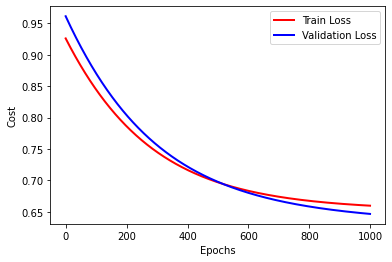

In [407]:
def plot(cost, cost_test):
  plt.xlabel('Epochs')
  plt.ylabel('Cost')
  plt.plot(np.arange(len(cost)), cost, 'r', linewidth = "2", label= 'Train Loss')
  plt.plot(np.arange(len(cost_test)), cost_test, 'b', linewidth = "2", label= 'Validation Loss')
  plt.legend()
  plt.show()
  
plot(cost, cost_test)

In [408]:
y_pred, y_proba= get_class(x_test)

In [409]:
accuracy(y_test, y_pred)

0.6818181818181818

# NN Class

In [466]:
# BGD
class NN:
  def __init__(self, x_test, y_test, size, num_epochs= 1000, lr= 0.001, threshold= 0.5):
    self.num_epochs= num_epochs
    self.lr= lr
    self.threshold= threshold
    self.cost_train= []
    self.size= size
    self.x_test= x_test
    self.y_test= y_test
    self.params= self.weight_initialization()

  def sigmoid(self,x):
    y = 1/(1+ np.exp(-x))
    return y
  
  def dsigmoid(self,x):
    y = sigmoid(x)*(1- sigmoid(x))
    return y


  def cross_entropy(self,y,y_pred):
    loss = -(np.mean((y*np.log(y_pred))+(1-y)*np.log(1-y_pred)))
    return loss
  
  def weight_initialization(self):
    input_dim= self.size[0]
    hidden_dim= self.size[1]
    output_dim= self.size[2]


    params = {
            'w1':np.random.rand(hidden_dim, input_dim)*0.01,
            'b1':np.random.rand(hidden_dim,1),
            'w2':np.random.rand(output_dim, hidden_dim)*0.01,
            'b2':np.random.rand(output_dim,1) 
        }

    return params

  def forward_pass(self, x):
    params= self.params
    z1=  params["w1"]@x.T + params["b1"]
    a1= self.sigmoid(z1)

    z2= params["w2"]@a1 + params["b2"]
    a2= self.sigmoid(z2)


    

    # ForwardPass
   
    return z1, a1, z2, a2
  
  def backward_pass(self, x, y):
    params= self.params

    # Backward
  # Forward pass
  
    z1, a1, z2, a2= self.forward_pass(x)
    m = x.shape[0]
  #Backward
    dw1= ((params["w2"].T@(a2-y)*self.dsigmoid(z1))@x)/m
    db1= np.sum((params["w2"].T@(a2-y))*(self.dsigmoid(z1)), axis = 1, keepdims=True)/m




    dw2= ((a2-y)@a1.T)/m
    db2= np.sum(a2-y, axis = 1, keepdims = True)/m

    return dw1, db1, dw2, db2

  def fit(self, x, y):



    for i in range(self.num_epochs):
      dw1, db1, dw2, db2 = self.backward_pass(x, y)
      # Get Params

      params= self.params

      params["w1"]= params["w1"] - (self.lr*dw1)
      params["b1"]= params["b1"]- (self.lr*db1)

      params["w2"]= params["w2"] - (self.lr*dw2)
      params["b2"]= params["b2"]- (self.lr*db2)

          # Get the Train Loss
      z1, a1, z2, a2 = self.forward_pass(x)

        #Compute the loss
      loss_train = self.cross_entropy(y,a2)
      self.cost_train.append(loss_train)

     
      

  
    
  
  def get_class(self, x):
    w1, b1, w2, b2= self.params['w1'], self.params['b1'], self.params['w2'], self.params['b2']
    _,_,_,proba= self.forward_pass(x) 
    proba= proba.squeeze(0)
    result= [1 if i> threshold else 0 for i in proba] # Convert proba to 0 or 1. hint: list comprehension
    return np.array(result), proba

  def accuracy(self, y,y_pred):
    return np.mean(y == y_pred)*100
  def plot(self):
    plt.xlabel('Epochs')
    plt.ylabel('Cost')
    plt.plot(np.arange(len(self.cost_train)), self.cost_train, 'r', linewidth = "2", label= 'Train Loss')
    plt.legend()
    plt.show()

In [467]:
size= [x_train.shape[1], 16, 1]
model= NN(x_test, y_test, size, num_epochs= 2000, lr= 0.001)

In [468]:
model.fit(x_train, y_train)

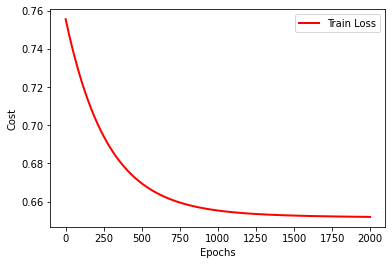

In [469]:
model.plot()

In [470]:
y_pred= model.get_class(x_test)

y_pred

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0.36513086, 0.36479426, 0.36363927, 0.36434106, 0.36296167,
        0.3640089 , 0.36314945, 0.36476164, 0.36340115, 0.3646563 ,
        0.36407435, 0.36376308, 0.36364414, 0.36627495, 0.36489376,
        0.3641839 , 0.3643671 , 0.36491103, 0.36250721, 0.36641623,
        0.36388494, 0.3646659 , 0.36461151, 0.36429526, 0.36354979,
        0.36360896, 0.3636713 , 0.36368355, 0.3645647 , 0.36491375,
        0.36533055, 0.36477097, 0.36411571, 0.36229206, 0.36311894,
    

In [471]:
model.accuracy(y_pred, y_test)

34.090909090909086